# Explore Reddit news comments
We have seen that the NYT data has a reasonable number of useful questions, but a limited number of articles.

Let's look at the comments posted on articles in `r/news`, a relatively active and (somewhat) moderated community. We might not be able to get all the articles but by restricting to open-access articles where people are (more) likely to actually read it, then we might be able to get a better distribution of training data.

In [1]:
from praw import Reddit
# client info from https://www.reddit.com/prefs/apps
client_id = '9SCiZpAKCyfaTQ'
client_secret = 'hQ2tGoUqpCizqJf2hNv0uP8cADw'
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)

Version 7.1.2 of praw is outdated. Version 7.1.3 was released 10 hours ago.


In [2]:
sub_name = 'news'
for submission in reddit_api.subreddit(sub_name).new(limit=20):
    print(submission.title)
    print(f'{len(list(submission.comments))} comments')

Modi’s Response to Farmer Protests in India Stirs Fears of a Pattern
0 comments
Kansas City Chiefs coach Britt Reid under investigation following car crash that left child with life-threatening injuries
0 comments
Woman, 95, Indicted on 10,000 Counts of Accessory to Murder in Nazi Camp
3 comments
Arrest in Thailand of second drug kingpin tightens dragnet on huge syndicate
0 comments
Sweeping new rules bring national security law into Hong Kong classrooms
0 comments
India restores 4G mobile internet in Kashmir after 550 days
1 comments
Woman, 95, Indicted on 10,000 Counts of Accessory to Murder in Nazi Camp
8 comments
2 children killed, 1 child injured in Ohio shooting
0 comments
California can't totally ban indoor worship, Supreme Court says
2 comments
Canada to Officially Open Door to Young Hong Kongers Next Week
2 comments
US to revoke terrorist designation of Houthis citing famine
0 comments
21 Savage rewarded biggest songwriter for 2020
2 comments
A new chameleon species may be the

Let's collect 1 month of submissions and their comments, to start.

We need help from PushShift ([here](https://github.com/dmarx/psaw)) to make the time range query work.

In [3]:
from praw import Reddit
from psaw import PushshiftAPI
from datetime import datetime

client_id = '9SCiZpAKCyfaTQ'
client_secret = 'hQ2tGoUqpCizqJf2hNv0uP8cADw'
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)

pushshift_reddit_api = PushshiftAPI(reddit_api)
start_date = (2018, 4, 1)
end_date = (2018, 4, 2)
start_time = int(datetime(*start_date).timestamp())
end_time = int(datetime(*end_date).timestamp())
subreddit_name = 'news'
submissions = pushshift_reddit_api.search_submissions(
    after=start_time,
    before=end_time, 
    subreddit=subreddit_name,
#     filter=['url', 'author', 'title', 'subreddit', 'comments'],
)
from tqdm import tqdm
retrieved_submissions = []
for i, submission_i in enumerate(submissions):
    retrieved_submissions.append(submission_i)
    if(i % 100 == 0):
        print(f'{i} submissions processed')

0 submissions processed
100 submissions processed
200 submissions processed
300 submissions processed
400 submissions processed
500 submissions processed
600 submissions processed
700 submissions processed
800 submissions processed


In [4]:
for submission_i in retrieved_submissions:
    comments_i = list(submission_i.comments)
    if(len(comments_i) > 0):
        print(comments_i)
        break

[Comment(id='dwo5e9a')]


In [5]:
import pandas as pd
from praw.models.reddit.more import MoreComments
comment_data = []
for i, submission_i in enumerate(retrieved_submissions):
    id_i = submission_i.id
    title_i = submission_i.title
    url_i = submission_i.url
    upvote_i = submission_i.ups
    ratio_i = submission_i.upvote_ratio
    comments_i = list(submission_i.comments)
    for comment_j in comments_i:
        # add extra comments if needed
        if(type(comment_j) is MoreComments):
            extra_comments_i = comment_j.comments()
            comments_i.extend(extra_comments_i)
        else:
            comment_id_j = comment_j.id
            comment_text_j = comment_j.body
            comment_upvote_j = comment_j.ups
            comment_author_j = comment_j.author
            comment_author_name_j = ''
            if(comment_author_j is not None):
                comment_author_name_j = comment_author_j.name
            comment_data_j = pd.Series(
                [id_i, title_i, url_i, upvote_i, ratio_i, comment_id_j, comment_text_j, comment_upvote_j, comment_author_name_j],
                index=['submission_ID', 'submission_title', 'submission_URL', 'submission_upvotes',
                       'submission_upvote_ratio', 'comment_ID', 'comment_text', 'comment_upvotes', 'comment_author']
            )
            comment_data.append(comment_data_j)
    if(i % 100 == 0):
        print(f'processed {i} submissions')
comment_data = pd.concat(comment_data, axis=1).transpose()

processed 0 submissions
processed 100 submissions
processed 200 submissions
processed 300 submissions
processed 400 submissions
processed 500 submissions
processed 600 submissions
processed 700 submissions
processed 800 submissions


In [6]:
## collect questions
from data_helpers import extract_questions
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
import re
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
question_matcher = re.compile('.+[a-zA-Z0-9]\?$')
assert question_matcher.match('is this a question?')
min_question_len = 5
comment_data = comment_data.assign(**{
    'comment_questions' : comment_data.loc[:, 'comment_text'].apply(lambda x: extract_questions(x, word_tokenizer, sent_tokenizer, question_matcher, min_question_len=min_question_len))
})

In [7]:
flat_questions = [y for x in comment_data.loc[:, 'comment_questions'].values for y in x]
print(flat_questions[:10])

['As opposed to regular Egyptian?', 'are you allowed to take diatomaceous earth on planes?', 'Whose plane did that passenger then go sit in?', 'Who were their seatmates?', "right beside this passenger's?", 'Anyone have any experience with it?', 'Out of curiosity has anyone tried putting their infested cloths/luggage in a airtight big ziplock or trash bag with dry ice (co2) and suffocate the bastards?', 'So, seat bugs?', "Didn't we almost have them extinct?", 'What the hell happened?']


What is the distribution of questions per article?

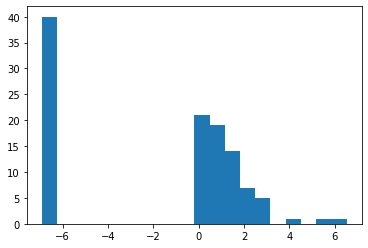

In [8]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
submission_total_question_counts = comment_data.groupby('submission_ID').apply(lambda x: len([z for y in x.loc[:, 'comment_questions'] for z in y]))
# log-scale
submission_total_question_counts = np.log(submission_total_question_counts + 0.001)
plt.hist(submission_total_question_counts, bins=20)
# plt.yscale('log')
plt.show()

Most articles have 0 questions, but a considerable chunk have 1-10 questions.

Out of a sample of articles, how many questions are (1) clarification and (2) likely answerable in the article?

In [9]:
import numpy as np
np.random.seed(123)
submission_question_counts = comment_data.groupby('submission_ID').apply(lambda x: x[x.loc[:, 'comment_questions'].apply(lambda y: len(y) > 0)].shape[0])
min_questions_per_submission = 5
submission_ids = submission_question_counts[submission_question_counts >= min_questions_per_submission].index.tolist()
submission_sample_size = 10
question_sample_size = 5
sample_submission_ids = np.random.choice(submission_ids, submission_sample_size, replace=False)
sample_comment_data = comment_data[comment_data.loc[:, 'submission_ID'].isin(sample_submission_ids)]
for submission_id_i, data_i in sample_comment_data.groupby('submission_ID'):
    title_i = data_i.loc[:, 'submission_title'].iloc[0]
    print(f'submission title {title_i}')
    data_i = data_i[data_i.loc[:, 'comment_questions'].apply(lambda x: len(x) > 0)]
    for j in range(question_sample_size):
#         print(data_i.iloc[j, :])
        question_j = data_i.iloc[j, :].loc['comment_questions'][0]
        print(f'\tquestion {j}: {question_j}')

submission title Video Shows Sacramento Sheriff’s Vehicle Striking Protester
	question 0: Sir, do you know why I had to stop you?
	question 1: Don't walk in front of a moving vehicle, or is this protester exempt from common sense?
	question 2: Was anyone here actually able to view the video, and if so - did it look like an accident or intentional?
	question 3: Why are they protesting?
	question 4: I wonder if it would be an adequate response to say you fled from striking a police officer with your car to avoid a confrontation with police?
submission title Inspector General reveals DoD can't verify where $3.1 billion was spent in Afghanistan
	question 0: Can we appreciate a moment that some of that money, per the article, was earmarked to train Afghan personnel to better account for spending?
	question 1: Is it just me or is there a similar headline popping up every few years?
	question 2: This isn't a direct assault on anyone in particular, but I'm getting sick of articles about corrup

- 0 0 1 1 0 = 40%
- 0 0 0 1 0 = 20%
- 0 0 0 0 0 = 0%
- 1 0 0 0 0 = 0%
- 0 0 1 0 0 = 20%
- 0 0 0 0 0 = 0%
- 0 0 0 1 0 = 20%
- 1 1 0 1 1 = 80%
- 1 0 0 1 1 = 60%
- 1 1 1 0 0 = 60%

Overall = 15/50 = 30% clarification questions that could be addressed in the article.

Not great but we can do some filtering (better URLs, upvoting, question overlap) to make the questions more suitable.

### Test news providers

How many of the news artices could be scraped (based on open-access providers)?

In [10]:
import re
domain_matcher = re.compile('(?<=https://)[^/]+(?=/)|(?<=http://)[^/]+(?=/)')
assert domain_matcher.search('https://www.google.com/test').group(0) == 'www.google.com'


In [11]:
comment_data = comment_data.assign(**{
    'URL_domain' : comment_data.loc[:, 'submission_URL'].apply(lambda x: domain_matcher.search(x).group(0) if domain_matcher.search(x) is not None else '')
})
# strip prefix
prefix_matcher = re.compile('^www\.')
comment_data = comment_data.assign(**{
    'URL_domain' : comment_data.loc[:, 'URL_domain'].apply(lambda x: prefix_matcher.sub('', x))
})

In [12]:
domain_counts = comment_data.loc[:, 'URL_domain'].value_counts()
display(domain_counts.head(50))

standard.co.uk             2462
nbcnews.com                 667
longwarjournal.org          256
foxnews.com                 118
news.com.au                  90
usatoday.com                 79
ajc.com                      56
bbc.com                      54
dailysabah.com               51
abc7news.com                 49
washington.cbslocal.com      46
sc.mp                        45
theguardian.com              42
sacramento.cbslocal.com      38
reuters.com                  34
freep.com                    32
ny1.com                      31
fox4kc.com                   30
cnn.com                      29
amp.nymag.com                26
fox26houston.com             23
telegraph.co.uk              22
kxxv.com                     19
citizen-times.com            19
aljazeera.com                18
latimes.com                  17
9news.com.au                 16
walk1000miles.co.uk          15
theverge.com                 15
news.sky.com                 14
khn.org                      13
law.utah

Which of the top-K domains are open access?

- standard.co.uk: 1
- nbcnews.com: 1
- longwarjournal.org: 1
- foxnews.com: 1
- news.com.au: 1
- usatoday.com: 1
- ajc.com: 1
- bbc.com: 1
- dailysabah.com: 1
- abc7news.com: 1
- washington.cbslocal.com: 1
- sc.mp: 1
- theguardian.com: 0
- sacramento.cbslocal.com: 1
- reuters.com: 1
- freep.com: 1
- ny1.com: 1
- fox4kc.com: 1
- cnn.com: 1
- amp.nymag.com: 0
- fox26houston.com: 1
- telegraph.co.uk: 0
- citizen-times.com: 1
- kxxv.com: 1
- aljazeera.com: 1
- latimes.com: 0
- 9news.com.au: 1
- walk1000miles.co.uk: 0
- theverge.com: 1
- news.sky.com: 1
- khn.org: 1
- law.utah.edu: 1
- edition.cnn.com: 1
- cbsnews.com: 1 
- cis.org: 1
- sacbee.com: 1 
- fresnobee.com: 1
- news-leader.com: 0
- nytimes.com: 0
- floridatoday.com: 0
- klfy.com: 1
- nzherald.co.nz: 0
- vaticannews.va: 1
- mtonews.com: 1
- bbc.co.uk: 1
- abc13.com: 1
- hosted2.ap.org: 1
- deseretnews.com: 1
- armytimes.com: 1
- mylot.com: 0

Total = 40/50 organizations are open access.

In [13]:
import numpy as np
is_open_access = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1 , 1, 1 , 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0])
sample_domain_counts = domain_counts.head(50)
open_access_article_estimate = (sample_domain_counts * is_open_access).sum() / sample_domain_counts.sum()
print(f'{open_access_article_estimate*100}% of articles shared are open-access')

96.69894366197182% of articles shared are open-access


OK! The sample may be non-representative but we seem to have a lot of open-access articles available, which means that we can learn mappings from articles to questions.

In [14]:
## save for later fml
comment_data.to_csv('../../data/reddit_news_comment_sample.gz', sep='\t', compression='gzip', index=False)

### Check Reddit member identity
Let's try to identify consistent reader groups based on prior behavior:

- age
- location
- topical experience (prior subreddit posting?)

In [18]:
import pandas as pd
comment_data = pd.read_csv('../../data/reddit_news_comment_sample.gz', sep='\t', compression='gzip', index_col=False)

In [1]:
from praw import Reddit
from psaw import PushshiftAPI

client_id = '9SCiZpAKCyfaTQ'
client_secret = 'hQ2tGoUqpCizqJf2hNv0uP8cADw'
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)

pushshift_reddit_api = PushshiftAPI(reddit_api)

Version 7.1.2 of praw is outdated. Version 7.1.3 was released 1 day ago.


In [171]:
## get sample comments from sample authors
import numpy as np
np.random.seed(123)
from tqdm import tqdm
from praw.models.reddit.comment import Comment
def get_sample_author_comments(author, reddit_api, end_time, comment_cols, comment_count=1000):
    author_comments = []
    author_redditor = reddit_api.redditor(author)
    complete_comment_cols = comment_cols+['author', 'subreddit']
    try:
        for i, comment_i in enumerate(author_redditor.new(limit=None)):
            # make sure it's a comment lol
            if(type(comment_i) is Comment):
                comment_time_i = comment_i.created_utc
                if(comment_time_i <= end_time and comment_i.body is not None):
                    subreddit_i = comment_i.subreddit.display_name
                    comment_data_i = [comment_i.__dict__.get(x) for x in comment_cols] + [author, subreddit_i]
                    comment_data_i = pd.Series(comment_data_i, index=complete_comment_cols)
                    author_comments.append(comment_data_i)
                if(len(author_comments) >= comment_count):
                    break
    # deleted author account?
    except Exception as e:
        print(f'ending collection for author {author} because error {e}')
    if(len(author_comments) > 0):
        author_comments = pd.concat(author_comments, axis=1).transpose()
    return author_comments
sample_author_count = 1000
sample_comment_count = 1000
sample_authors = np.random.choice(comment_data.loc[:, 'comment_author'].unique(), sample_author_count, replace=False)
sample_author_comments = []
comment_cols = ['author_flair_text', 'id', 'body', 'subreddit', 'parent_id']
end_date = (2018, 4, 2)
end_time = int(datetime(*end_date).timestamp())
for sample_author_i in tqdm(sample_authors):
    sample_comments_i = get_sample_author_comments(sample_author_i, reddit_api, end_time, comment_cols, comment_count=sample_comment_count)
    sample_author_comments.append(sample_comments_i)
# remove null comments
sample_author_comments = list(filter(lambda x: type(x) is not list, sample_author_comments))
sample_author_comments = pd.concat(sample_author_comments, axis=0)
# remove null comments
sample_author_comments = sample_author_comments[sample_author_comments.loc[:, 'body'].apply(lambda x: x is not None)]

  0%|          | 3/1000 [00:22<2:00:28,  7.25s/it]

ending collection for author Heythatispoop because error received 403 HTTP response


  4%|▍         | 40/1000 [03:57<1:39:10,  6.20s/it]

ending collection for author nan because error __str__ returned non-string (type float)


  6%|▋         | 65/1000 [06:24<1:56:29,  7.48s/it]

ending collection for author whatsthatbutt because error received 403 HTTP response


 10%|█         | 104/1000 [10:19<1:36:04,  6.43s/it]

ending collection for author BoondockSaint45 because error received 403 HTTP response


 11%|█         | 106/1000 [10:22<1:14:00,  4.97s/it]

ending collection for author OneFallsAnotherYalls because error received 403 HTTP response


 16%|█▌        | 162/1000 [16:04<1:30:34,  6.49s/it]

ending collection for author greenSixx because error received 403 HTTP response


 18%|█▊        | 181/1000 [17:53<1:16:27,  5.60s/it]

ending collection for author psxpetey because error received 403 HTTP response


 20%|█▉        | 196/1000 [18:56<53:02,  3.96s/it]  

ending collection for author boozeshoes because error received 403 HTTP response


 20%|██        | 204/1000 [19:46<1:31:19,  6.88s/it]

ending collection for author matt23x because error received 403 HTTP response


 21%|██        | 207/1000 [20:03<1:26:18,  6.53s/it]

ending collection for author iamkitkatbar because error received 403 HTTP response


 24%|██▍       | 244/1000 [24:10<1:33:41,  7.44s/it]

ending collection for author Whitehobasher1 because error received 403 HTTP response


 29%|██▉       | 294/1000 [29:49<1:19:30,  6.76s/it]

ending collection for author PineapplePoppadom because error received 403 HTTP response


 30%|███       | 304/1000 [30:35<54:39,  4.71s/it]  

ending collection for author mghoffmann because error received 403 HTTP response


 32%|███▏      | 321/1000 [31:56<34:29,  3.05s/it]  

ending collection for author collateralvincent because error received 403 HTTP response


 33%|███▎      | 334/1000 [33:18<1:09:00,  6.22s/it]

ending collection for author dadankness because error received 403 HTTP response


 34%|███▍      | 340/1000 [33:46<55:57,  5.09s/it]  

ending collection for author Industrialbonecraft because error received 403 HTTP response


 36%|███▌      | 355/1000 [35:17<1:13:07,  6.80s/it]

ending collection for author altaltaltpornaccount because error received 403 HTTP response


 37%|███▋      | 367/1000 [36:25<1:10:32,  6.69s/it]

ending collection for author CrackerBucket because error received 403 HTTP response


 41%|████      | 409/1000 [40:05<1:04:36,  6.56s/it]

ending collection for author Poz_My_Neg_Fuck_Hole because error received 403 HTTP response


 42%|████▏     | 422/1000 [40:57<51:23,  5.33s/it]  

ending collection for author ibuprofen87 because error received 403 HTTP response


 49%|████▉     | 490/1000 [47:12<25:13,  2.97s/it]  

ending collection for author stephen_bannon because error received 403 HTTP response
ending collection for author Goodguy75 because error received 403 HTTP response


 53%|█████▎    | 530/1000 [51:28<35:20,  4.51s/it]  

ending collection for author newcarcaviar4star because error received 403 HTTP response


 56%|█████▌    | 562/1000 [54:14<40:20,  5.53s/it]  

ending collection for author donkierweed because error received 403 HTTP response


 57%|█████▋    | 568/1000 [54:36<28:27,  3.95s/it]

ending collection for author CaughtInTheFire666 because error received 403 HTTP response


 57%|█████▋    | 570/1000 [54:39<23:06,  3.22s/it]

ending collection for author uncreative21 because error received 403 HTTP response


 62%|██████▏   | 615/1000 [59:17<44:49,  6.99s/it]

ending collection for author cmdertx because error received 403 HTTP response


 62%|██████▏   | 622/1000 [59:53<38:57,  6.18s/it]

ending collection for author HerNameWasMystery22 because error received 403 HTTP response


 64%|██████▎   | 636/1000 [1:01:19<46:31,  7.67s/it]

ending collection for author LeddHead because error received 403 HTTP response


 64%|██████▍   | 638/1000 [1:01:26<38:31,  6.39s/it]

ending collection for author MagicalUnibeefs because error received 403 HTTP response


 66%|██████▋   | 663/1000 [1:03:59<34:08,  6.08s/it]

ending collection for author Mizarrk because error received 403 HTTP response


 68%|██████▊   | 683/1000 [1:05:51<27:21,  5.18s/it]

ending collection for author Zeknichov because error received 403 HTTP response


 71%|███████   | 710/1000 [1:08:34<28:03,  5.81s/it]

ending collection for author twol3g1t because error received 403 HTTP response


 71%|███████   | 712/1000 [1:08:41<24:17,  5.06s/it]

ending collection for author agobr because error received 403 HTTP response


 75%|███████▍  | 746/1000 [1:11:47<22:13,  5.25s/it]

ending collection for author hnicgibbs because error received 403 HTTP response


 77%|███████▋  | 768/1000 [1:13:59<18:51,  4.88s/it]

ending collection for author TheRealLegitCuck because error received 403 HTTP response
ending collection for author DesignGhost because error received 403 HTTP response


 78%|███████▊  | 776/1000 [1:14:49<26:23,  7.07s/it]

ending collection for author Stayathomepyrat because error received 403 HTTP response


 78%|███████▊  | 779/1000 [1:14:54<16:08,  4.38s/it]

ending collection for author insidezone64 because error received 403 HTTP response


 78%|███████▊  | 784/1000 [1:15:22<26:18,  7.31s/it]

ending collection for author Spitfire_Akagi because error received 403 HTTP response


 80%|███████▉  | 796/1000 [1:16:17<13:19,  3.92s/it]

ending collection for author Hey_There_Fancypants because error received 403 HTTP response


 80%|████████  | 804/1000 [1:17:02<16:04,  4.92s/it]

ending collection for author Hurrrturrrn because error received 403 HTTP response


 82%|████████▏ | 815/1000 [1:18:00<16:41,  5.41s/it]

ending collection for author HungrySquirtle because error received 403 HTTP response


 84%|████████▎ | 835/1000 [1:19:55<12:29,  4.54s/it]

ending collection for author MaybeaskQuestions because error received 403 HTTP response


 85%|████████▍ | 849/1000 [1:21:27<19:05,  7.59s/it]

ending collection for author throwaway2600god because error received 403 HTTP response


 85%|████████▌ | 852/1000 [1:21:34<11:01,  4.47s/it]

ending collection for author SunshinyRainbows2017 because error received 403 HTTP response


 87%|████████▋ | 867/1000 [1:23:16<14:04,  6.35s/it]

ending collection for author Vernon_Roche1 because error received 403 HTTP response


 88%|████████▊ | 881/1000 [1:24:35<11:19,  5.71s/it]

ending collection for author Akai_Hana because error received 403 HTTP response


 89%|████████▉ | 889/1000 [1:25:21<11:01,  5.96s/it]

ending collection for author vtesterlwg because error received 403 HTTP response


 90%|█████████ | 902/1000 [1:26:46<09:05,  5.57s/it]

ending collection for author spread_thin because error received 403 HTTP response


 90%|█████████ | 905/1000 [1:26:50<05:02,  3.19s/it]

ending collection for author NardDogAndy because error received 403 HTTP response


 91%|█████████ | 910/1000 [1:27:25<09:46,  6.52s/it]

ending collection for author Wajirock because error received 403 HTTP response


 94%|█████████▍| 939/1000 [1:30:32<06:32,  6.44s/it]

ending collection for author abortion_control because error received 403 HTTP response


 96%|█████████▌| 960/1000 [1:32:28<02:54,  4.37s/it]

ending collection for author planetcollide because error received 403 HTTP response
ending collection for author MusteredCourage because error received 403 HTTP response


 96%|█████████▋| 963/1000 [1:32:50<03:56,  6.39s/it]

ending collection for author smegthis1 because error received 403 HTTP response


 98%|█████████▊| 977/1000 [1:34:18<02:21,  6.15s/it]

ending collection for author BayernMunich22 because error received 403 HTTP response


100%|██████████| 1000/1000 [1:36:28<00:00,  5.79s/it]


In [174]:
print(sample_author_comments.shape[0])
print(f'{sample_author_comments.loc[:, "author"].nunique()} unique sample authors')

89910
339 unique sample authors


In [175]:
## save for posterity fml
sample_author_comments.to_csv('../../data/reddit_news_author_comment_sample.gz', sep='\t', compression='gzip', index=False)

Now let's check for identity cues from prior comments.

- Age (regexes "I am X years old")
- Location (using NER + geopy? this requires identifying article location)
- Prior topical experience (subreddit distribution, topic counts...this requires aligning with news article topic)

### Test ages

In [176]:
## ages
import numpy as np
def extract_age(text, age_matcher, age_err_cutoff=5):
    combined_text = ' '.join(text).lower()
    age_match = age_matcher.findall(combined_text)
    approx_age = -1
    if(len(age_match) > 0):
        ages = list(map(lambda x: int(x), age_match))
        # if ages have larger STD than expected, ignore
        age_std = np.std(ages)
        if(age_std < age_err_cutoff):
            approx_age = int(np.mean(ages))
    return approx_age
import re
age_matcher_expr = [
    '(?<=i am )[0-9]+(?= years old)',
    '(?<=i\'m )[0-9]+(?= years old)',
    '(?<=i am a )[0-9]+(?= year old)'
    '(?<=i\'m a )[0-9]+(?= year old)',
]
age_matcher = re.compile('|'.join(age_matcher_expr))
age_err_cutoff = 5
test_text = ['I am 10 years old', 'this is another sample sentence', 'i am 11 years old']
test_text_age = extract_age(test_text, age_matcher, age_err_cutoff=age_err_cutoff)
print(f'test age = {test_text_age}')
from tqdm import tqdm
tqdm.pandas()
sample_author_ages = sample_author_comments.groupby('author').progress_apply(
    lambda x: extract_age(x.loc[:, 'body'].values, age_matcher, age_err_cutoff=age_err_cutoff)
)
# remove null ages
sample_author_ages = sample_author_ages[sample_author_ages != -1]

/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
 17%|█▋        | 56/339 [00:00<00:01, 270.83it/s]

test age = 10


100%|██████████| 339/339 [00:01<00:00, 284.03it/s]


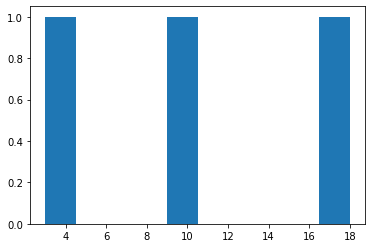

In [177]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(sample_author_ages)
plt.show()

OK! We only see a few self-disclosures of age, about 1% (3/339).

### Test location

In [86]:
# import geocoder
# x = geocoder.osm('California', method='geocode')
print(x.geojson['features'][0]['properties']['country_code'])

us


In [ ]:
## location
from data_helpers import extract_all_named_entities
def extract_NE_locations(text, location_matcher, word_tokenizer, sent_tokenizer, ner_pipeline, valid_NE_types={'GPE'}):
    locations = []
    for text_i in text:
        sents = sent_tokenizer.tokenize(text_i)
        for sent_j in sents:
            location_match_j = location_matcher.findall(sent_j)
            if(len(location_match_j) > 0):
                NE_j = extract_all_named_entities(sent_j, ner_pipeline, valid_NE_types=valid_NE_types)
                NE_j = list(map(lambda x: x.replace('_', ' '), NE_j))
                # look for overlaps
                valid_location_match_j = []
                for location_match_k in location_match_j:
                    NE_matches_k = list(filter(lambda x: x in location_match_k, NE_j))
                    valid_location_match_j.extend(NE_matches_k)
                if(len(valid_location_match_j) > 0):
                    locations.extend(valid_location_match_j)
    return locations
import geocoder
def estimate_locations(text_locations):
    ## TODO: keep full location for e.g. state comparison?
    location_estimates = list(map(lambda x: geocoder.osm(x, method='geocode'), text_locations))
    # get countries for valid estimates
    location_countries = []
    for location_estimate_i in location_estimates:
        if(location_estimate_i.geojson is not None and len(location_estimate_i.geojson['features']) > 0):
            location_country = location_estimate_i.geojson['features'][0]['properties']['country_code']
            location_countries.append(location_country)
    return location_countries
def estimate_country(locations, location_pct_cutoff=0.5):
    location_country_est = 'UNK'
    country_counts = pd.Series(locations).value_counts() / len(locations)
    country_counts.sort_values(inplace=True, ascending=False)
    # get max country
    max_country_count = country_counts.iloc[0]
    if(max_country_count >= location_pct_cutoff):
        location_country_est = country_counts.index[0]
    return location_country_est
def full_location_pipeline(text, location_matcher, 
                           word_tokenizer, sent_tokenizer, 
                           ner_pipeline, 
                           valid_NE_types={'GPE'},
                           location_pct_cutoff=0.5):
    locations = extract_NE_locations(text, location_matcher, word_tokenizer, sent_tokenizer, ner_pipeline, valid_NE_types=valid_NE_types)
    location_country_est = 'UNK'
    if(len(locations) > 0):
        location_countries = estimate_locations(locations)
        location_country_est = estimate_country(location_countries, location_pct_cutoff=location_pct_cutoff)
    return location_country_est

In [95]:
location_matcher = re.compile('(?<=I am from )[a-zA-Z0-9\, ]+|(?<=I live in )[a-zA-Z0-9 ]+')
test_text = ["I am from Florida, nice to meet you"]
# step 1: get locations
from stanza import Pipeline
nlp_pipeline = Pipeline(lang='en', processors='tokenize,ner', use_gpu=False)
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
valid_NE_types = {'GPE'}
test_NE_locations = extract_NE_locations(test_text, location_matcher, 
                                         word_tokenizer, sent_tokenizer, 
                                         nlp_pipeline, valid_NE_types=valid_NE_types)
print(test_NE_locations)
# step 2: resolve locations
# import geopy
test_approx_locations = estimate_locations(test_NE_locations)
print(f'all countries = {test_approx_locations}')
# # step 3: identify most consistent country among locations
location_pct_cutoff = 0.5
test_approx_country = estimate_country(test_approx_locations, location_pct_cutoff=location_pct_cutoff)
print(f'approx country = {test_approx_country}')
location_country_est = full_location_pipeline(test_text, location_matcher, 
                                              word_tokenizer, sent_tokenizer, 
                                              nlp_pipeline, 
                                              valid_NE_types=valid_NE_types,
                                              location_pct_cutoff=location_pct_cutoff)
print(f'location country est. {location_country_est}')

2021-02-07 17:31:03 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2021-02-07 17:31:03 INFO: Use device: cpu
2021-02-07 17:31:03 INFO: Loading: tokenize
2021-02-07 17:31:03 INFO: Loading: ner
2021-02-07 17:31:04 INFO: Done loading processors!


['Florida']
all countries = ['us']
approx country = us
location country est. us


In [97]:
from tqdm import tqdm
author_countries = []
for author_i, data_i in tqdm(sample_author_comments.groupby('author')):
    text_i = data_i.loc[:, 'body'].values
    location_country_est_i = full_location_pipeline(text_i, location_matcher,
                                                    word_tokenizer, sent_tokenizer,
                                                    nlp_pipeline, 
                                                    valid_NE_types=valid_NE_types,
                                                    location_pct_cutoff=location_pct_cutoff)
    author_countries.append(location_country_est_i)

100%|██████████| 339/339 [01:02<00:00,  5.39it/s]


In [99]:
author_country_counts = pd.Series(author_countries).value_counts()
print(author_country_counts)

UNK    285
us      33
it       3
ca       3
gb       3
au       2
jp       2
ie       1
ae       1
fr       1
br       1
se       1
hu       1
tw       1
th       1
dtype: int64


As expected, heavy representation from US people and less from others. Overall we get about 54/339 ~ 16% availability of locations based on self-disclosure.

### Test topical alignment

How many authors have previously commented about topics that are similar to the submissions mentioned?

Let's train a topic model on both the submission titles and the prior comments, and then look for comments with reasonably high alignment.

In [ ]:
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora.dictionary import Dictionary
submission_comment_texts = list(comment_data.loc[:, 'submission_title'].values) + list(sample_author_comments.loc[:, 'body'].values)
# tokenize
from nltk.tokenize import WordPunctTokenizer
word_tokenizer = WordPunctTokenizer()
submission_comment_text_tokens = list(map(lambda x: word_tokenizer.tokenize(x.lower()), submission_comment_texts))
# remove stop words lol
from stop_words import get_stop_words
en_stops = get_stop_words('en')
submission_comment_text_tokens = list(map(lambda x: list(filter(lambda y: y not in en_stops, x)), submission_comment_text_tokens))
submission_comment_dict = Dictionary(submission_comment_text_tokens)
submission_comment_corpus = list(map(lambda x: submission_comment_dict.doc2bow(x), submission_comment_text_tokens))

In [137]:
## test different topics for coherence
num_topics = [20, 30, 50, 100]
coherence_vals = []
for num_topics_i in num_topics:
    print(f'testing topics={num_topics_i}')
    lda_model = LdaModel(submission_comment_corpus, num_topics=num_topics_i, id2word=submission_comment_dict)
    coherence_model = CoherenceModel(model=lda_model, corpus=submission_comment_corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    coherence_vals.append(coherence)

testing topics=20
testing topics=30
testing topics=50
testing topics=100


In [138]:
print(coherence_vals)

[-7.192421609994378, -6.834884034833574, -6.096277888055888, -6.373581459396098]


Let's use $K=50$.

In [139]:
## retrain model etc.
best_num_topics = 50
lda_model = LdaModel(submission_comment_corpus, num_topics=best_num_topics, id2word=submission_comment_dict)
## show top words for all topics
for topic_i in range(best_num_topics):
    print(f'topic = {topic_i}, words = {lda_model.show_topic(topic_i)}')

topic = 0, words = [('worth', 0.21575102), ('ex', 0.13222744), ('student', 0.0653791), ('--', 0.0366315), ('breaks', 0.03551335), ('slap', 0.0142751895), ('fruit', 0.012818649), ('hockey', 0.0020508156), (',', 3.411261e-05), ('.', 8.224714e-06)]
topic = 1, words = [('say', 0.4543252), ('death', 0.08502652), ('americans', 0.06504055), ('store', 0.043635387), ('across', 0.042917866), ('beer', 0.03608055), ('stealing', 0.014830403), ('charged', 0.012518345), ('statues', 0.008471615), ('offensive', 0.0076992773)]
topic = 2, words = [('one', 0.57217103), ('man', 0.12053903), ('parents', 0.05313702), (',', 0.041535184), ('killing', 0.027288936), ('.', 0.0186217), ('pass', 0.016659392), ('lead', 0.016585557), ('orange', 0.008744537), ('steel', 0.0074284417)]
topic = 3, words = [('google', 0.13761283), ('north', 0.084816284), ('texas', 0.07477755), ('florida', 0.063822664), ('foot', 0.054939717), ('pool', 0.048612863), ('swimming', 0.035046965), ('soul', 0.01941438), ('stars', 0.017702736), ('

topic = 37, words = [(':', 0.46252766), ('news', 0.12249927), ('bill', 0.08745987), ('red', 0.05301275), ('son', 0.03817465), ('propaganda', 0.03036778), ('india', 0.014309588), ('mars', 0.006676914), ('nasa', 0.0038980406), ('guards', 0.0027859465)]
topic = 38, words = [('university', 0.11542098), ('row', 0.03300526), ('indiana', 0.008662793), ('first', 1.2925738e-05), ("'", 1.2804208e-05), ('time', 1.2770847e-05), ('new', 1.2640888e-05), ('ever', 1.26002615e-05), ('t', 1.2588787e-05), ('york', 1.2553794e-05)]
topic = 39, words = [('never', 0.5424242), ('water', 0.12725824), ('town', 0.039564162), ('pop', 0.020365398), ('applied', 0.015733054), ('savings', 0.007987896), ('unfairly', 0.0033997288), ('.', 0.0017262301), ('cape', 0.00097258855), ('time', 4.0043382e-05)]
topic = 40, words = [("'", 0.30499983), ('.', 0.22245687), ('t', 0.19679876), (',', 0.09234089), ('m', 0.056481354), ('know', 0.027263222), ('didn', 0.020727579), ('like', 0.020022186), ('can', 0.009824202), ('things', 0.

We see some reasonable connections, like state names (topic 3) and international news (topic 10).

Let's label all submissions and all authors, then look for submissions/authors with high overlap.

In [161]:
def convert_docs_to_topics(docs, stops, tokenizer, corpus_dict, model):
    # get tokens
    doc_tokens = list(map(lambda x: word_tokenizer.tokenize(x.lower()), docs))
    doc_tokens = list(map(lambda x: list(filter(lambda y: y not in stops, x)), doc_tokens))
    # get corpus
    doc_corpus = list(map(lambda x: corpus_dict.doc2bow(x), doc_tokens))
    # get topics
    doc_topics = list(map(lambda x: pd.Series(list(zip(*x))[1], index=list(zip(*x))[0]), 
                          model.get_document_topics(doc_corpus, minimum_probability=0.)))
    doc_topics = pd.concat(doc_topics, axis=1).transpose()
    return doc_topics
submission_corpus = comment_data.loc[:, 'submission_title'].drop_duplicates().values
comment_corpus = sample_author_comments.loc[:, 'body'].values
submission_doc_topics = convert_docs_to_topics(submission_corpus, en_stops, word_tokenizer, submission_comment_dict, lda_model)
comment_doc_topics = convert_docs_to_topics(comment_corpus, en_stops, word_tokenizer, submission_comment_dict, lda_model)

In [162]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
submission_comment_topic_sim = cosine_similarity(submission_doc_topics, comment_doc_topics)
print(submission_comment_topic_sim.shape)
sample_submission_idx = list(range(10))
top_comments_per_submission = 5
for sample_submission_idx_i in sample_submission_idx:
    print(f'submission doc = {submission_corpus[sample_submission_idx_i]}')
    top_comment_idx = list(reversed(np.argsort(submission_comment_topic_sim[sample_submission_idx_i, :])[-top_comments_per_submission:]))
    for comment_idx_j in top_comment_idx:
        print(f'\tcomment sim={submission_comment_topic_sim[sample_submission_idx_i, comment_idx_j]}')
        print(f'\tcomment doc={comment_corpus[comment_idx_j]}')

(108, 89903)
submission doc = Africa Egyptian government threatens foreign journalists over coverage of election
	comment sim=0.9828344405457891
	comment doc=Time to recharge the kindle 
	comment sim=0.9828344405457891
	comment doc=I hear you on Todd and Tyler all the time!
	comment sim=0.9828344405457891
	comment doc=Just in time for Lent too! Fish Friday!
	comment sim=0.9828344380520084
	comment doc=dont use it as toilet paper next time
	comment sim=0.9828344380520084
	comment doc=Think it adds 4% of market value on top of what it is at the time of buying not quite sure but thats my 2 cent
submission doc = Bed bugs found in Kansas City airport seating area
	comment sim=0.9738770788186343
	comment doc=Found the Indian programmer
	comment sim=0.7989469295715768
	comment doc=I think we found one of dem secret Russian trolls
	comment sim=0.7040547339183398
	comment doc=Stop looking at screens from phones and computers at least 2 hours before bed. It wrecks your sleep schedule 
	comment s

OK! So a lot of the "similar" comments tend to share some words/concepts in common but not as closely as I would have thought. We may have to restrict the "prior comments" to `r/news`, i.e. how often did the commenter make a comment on an article with a similar topic.

### Test prior subreddit comments
Let's look at the same authors' prior comments in `r/news` specifically to address their similarity in topical experience.

This will require getting the parent submission information too...awesome.

In [1]:
## reload etc.
import pandas as pd
sample_author_comments = pd.read_csv('../../data/reddit_news_author_comment_sample.gz', sep='\t', compression='gzip', index_col=False).drop('subreddit.1', axis=1)
display(sample_author_comments.head())

,author_flair_text,id,body,subreddit,parent_id,author
0,NaN,dwmkw5e,Explain that Mossad agents work at Black Cube ...,worldnews,t1_dwmk3k4,FrivolousBanter
1,NaN,dwmjfml,+20db if listening on Soundcloud.\n\n-40db if ...,dataisbeautiful,t3_88q0d1,FrivolousBanter
2,NaN,dwmjbdo,Alternate title: I payed 1 mana to win the gam...,hearthstone,t3_88ntm2,FrivolousBanter
3,NaN,dwmj1ip,Why is this even on the front page? Oh because...,pics,t3_88pnfc,FrivolousBanter
4,NaN,dwmito0,Don't even bother. It's the same 5 racists in ...,news,t1_dwlon2e,FrivolousBanter


In [2]:
print(f'{(sample_author_comments.loc[:, "subreddit"]=="news").sum()}/{sample_author_comments.shape[0]} <news> comments')

8877/89913 <news> comments


In [3]:
## how many unique parent comments do we need to collect??
news_sample_author_comments = sample_author_comments[sample_author_comments.loc[:, 'subreddit']=='news']
print(f'{news_sample_author_comments.loc[:, "parent_id"].nunique()} unique parent comments')

8281 unique parent comments


In [4]:
from praw import Reddit
from psaw import PushshiftAPI

client_id = '9SCiZpAKCyfaTQ'
client_secret = 'hQ2tGoUqpCizqJf2hNv0uP8cADw'
user_agent = 'user_agent_123'
reddit_api = Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent,
    check_for_async=False,
)

pushshift_reddit_api = PushshiftAPI(reddit_api)

Version 7.1.2 of praw is outdated. Version 7.1.4 was released 19 hours ago.


In [42]:
from tqdm import tqdm
news_comment_parent_ids = news_sample_author_comments.loc[:, 'parent_id'].apply(lambda x: x.split('_')[1]).unique()
news_comment_parent_submission_data = []
for parent_id_i in tqdm(news_comment_parent_ids):
    parent_submission_i = reddit_api.submission(parent_id_i)
    # try to retrieve submission
    try:
        parent_title_i = parent_submission_i.title
#         print(f'title = {parent_title_i}')
        parent_upvotes_i = parent_submission_i.ups
        parent_upvote_ratio_i = parent_submission_i.upvote_ratio
        parent_submission_data_i = [parent_id_i, parent_title_i, parent_upvotes_i, parent_upvote_ratio_i]
        parent_submission_data_i = pd.Series(parent_submission_data_i, index=['parent_id', 'parent_title', 'parent_upvotes', 'parent_upvote_ratio'])
        news_comment_parent_submission_data.append(parent_submission_data_i)
    except Exception as e:
#         print(f'error = {e}')
        pass
news_comment_parent_submission_data = pd.concat(news_comment_parent_submission_data, axis=1).transpose()

100%|██████████| 8281/8281 [1:09:23<00:00,  1.99it/s]


In [43]:
print(f'{news_comment_parent_submission_data.shape[0]}/{len(news_comment_parent_ids)} submissions retrieved')

2087/8281 submissions retrieved


In [44]:
## get original comment data
comment_data = pd.read_csv('../../data/reddit_news_comment_sample.gz', sep='\t', compression='gzip', index_col=False)

In [45]:
comment_data.head()

,submission_ID,submission_title,submission_URL,submission_upvotes,submission_upvote_ratio,comment_ID,comment_text,comment_upvotes,comment_author,comment_questions,URL_domain
0,88wlu3,Africa Egyptian government threatens foreign j...,https://www.independent.co.uk/news/world/afric...,94,0.91,dwo5e9a,Africa Egyptian? As opposed to regular Egyptian?,13,johnsoone,['As opposed to regular Egyptian?'],independent.co.uk
1,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwo1cjb,Just got our first home infestation within the...,96,jfoobar,[],usatoday.com
2,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwnsk0j,"ah, fuck. are you allowed to take diatomaceous...",459,SomethingWitty4this,['are you allowed to take diatomaceous earth o...,usatoday.com
3,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwntgsb,Burn down the airport,306,VTFC,[],usatoday.com
4,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwnxjqv,The passenger who carried the bugs into the te...,96,Gasonfires,[],usatoday.com


In [93]:
## run topic modeling on parent submission titles and original submission titles
from gensim.models import LdaModel
num_topics = 50
## train on submissions, test on comments? unlikely to generalize but sure
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
from nltk.tokenize import WordPunctTokenizer
from stop_words import get_stop_words
PUNCT = list(',.?!;:"\'-’')
def convert_docs_to_corpus(docs, doc_dict=None):
    word_tokenizer = WordPunctTokenizer()
    doc_tokens = list(map(lambda x: word_tokenizer.tokenize(x.lower()), docs))
    # remove stop words
    en_stops = set(get_stop_words('en') + PUNCT)
    doc_tokens = list(map(lambda x: list(filter(lambda y: y not in en_stops, x)), doc_tokens))
    if(doc_dict is None):
        doc_dict = Dictionary(doc_tokens)
    doc_corpus = list(map(lambda x: doc_dict.doc2bow(x), doc_tokens))
    return doc_dict, doc_corpus
# tokenize
# submission_dict, submission_corpus = convert_docs_to_corpus(comment_data.loc[:, 'submission_title'].values)

In [54]:
def convert_docs_to_topics(docs, doc_dict, model):
    doc_dict, doc_corpus = convert_docs_to_corpus(docs, doc_dict=doc_dict)
    # get topics
    doc_topics = list(map(lambda x: pd.Series(list(zip(*x))[1], index=list(zip(*x))[0]), 
                          model.get_document_topics(doc_corpus, minimum_probability=0.)))
    doc_topics = pd.concat(doc_topics, axis=1).transpose()
    return doc_topics

In [94]:
from gensim.models import CoherenceModel
# fit model
num_topics = [10, 20, 50, 100]
submission_docs = list(comment_data.loc[:, 'submission_title'].unique())
parent_submission_docs = list(news_comment_parent_submission_data.loc[:, 'parent_title'].unique())
combined_submission_docs = submission_docs + parent_submission_docs
combined_submission_dict, combined_submission_corpus = convert_docs_to_corpus(combined_submission_docs)
coherence_vals = []
for num_topic_i in num_topics:
    lda_model = LdaModel(combined_submission_corpus, num_topics=num_topic_i, id2word=combined_submission_dict)
    # compute coherence
    coherence_model = CoherenceModel(model=lda_model, corpus=combined_submission_corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    coherence_vals.append(coherence)
print(coherence_vals)

[-15.532585885740536, -16.664627082062275, -17.84028066707488, -15.954842995802938]


In [95]:
# compute all topics
best_num_topics = 10
best_lda_model = LdaModel(combined_submission_corpus, num_topics=best_num_topics, id2word=combined_submission_dict)
submission_doc_topics = convert_docs_to_topics(submission_docs, combined_submission_dict, best_lda_model)
parent_submission_doc_topics = convert_docs_to_topics(parent_submission_docs, combined_submission_dict, best_lda_model)

In [100]:
## sanity check: top words per topic
for x in best_lda_model.print_topics(num_words=20):
    print(f'- topic {x[0]}: {x[1]}')

- topic 0: 0.009*"says" + 0.009*"attack" + 0.009*"spy" + 0.008*"columbus" + 0.008*"sexual" + 0.008*"now" + 0.008*"000" + 0.008*"men" + 0.007*"s" + 0.007*"woman" + 0.006*"women" + 0.006*"time" + 0.006*"chemical" + 0.006*"will" + 0.006*"scientists" + 0.006*"school" + 0.006*"ex" + 0.006*"va" + 0.006*"days" + 0.006*"offenders"
- topic 1: 0.009*"s" + 0.009*"muslims" + 0.009*"investigators" + 0.009*"test" + 0.009*"discovered" + 0.009*","" + 0.008*"u" + 0.008*"people" + 0.006*"hollywood" + 0.006*"ford" + 0.006*"attacks" + 0.005*"new" + 0.005*"teens" + 0.005*"suspected" + 0.005*"back" + 0.005*"hold" + 0.005*"crash" + 0.005*"police" + 0.005*"sign" + 0.005*"put"
- topic 2: 0.014*"school" + 0.012*"student" + 0.011*"tsa" + 0.010*"s" + 0.010*"man" + 0.010*"shooting" + 0.008*"boy" + 0.008*"county" + 0.007*"nasa" + 0.007*"longer" + 0.007*"us" + 0.007*"police" + 0.006*"teacher" + 0.006*"high" + 0.006*"allegedly" + 0.006*"go" + 0.006*"42" + 0.006*"prostitution" + 0.006*"less" + 0.005*"year"
- topic 3: 

We have the folllowing topics:

- `crime`
- `investigation`
- `education`
- `police`
- `criminal_evidence`
- `criminal_cases`
- `international_violence`
- `national`
- `international_politics`
- `international_business?`

What are the most similar articles, between the original submissions and the parent submissions?

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
submission_vs_parent_comment_submission_sim = cosine_similarity(
    submission_doc_topics, parent_submission_doc_topics
)
print(submission_vs_parent_comment_submission_sim.shape)

(108, 2086)


In [102]:
## sample docs and similarity
import numpy as np
sample_submission_count = 10
top_sim_submissions = 5
for i in range(sample_submission_count):
    print(f'{i}. submission = {comment_submission_docs[i]}')
    top_sim_idx_i = list(reversed(np.argsort(submission_vs_parent_comment_submission_sim[i, :])[-top_sim_submissions:]))
    for idx_j in top_sim_idx_i:
        print(f'\tsubmission with sim = {submission_vs_parent_comment_submission_sim[i, idx_j]}: {parent_comment_submission_docs[idx_j]}')

0. submission = Africa Egyptian government threatens foreign journalists over coverage of election
	submission with sim = 0.9999999999913007: Women's March Returns a Year Later, as Movement Evolves
	submission with sim = 0.9999999999202936: Gregg Allman, Soulful Trailblazer of Southern Rock, Dies at 69
	submission with sim = 0.9999999998689756: Man pours boiling water on gay Atlanta couple in bed
	submission with sim = 0.9999999998532194: Wendy's replacing workers with machines because of rising wage cost
	submission with sim = 0.9999999998010338: Dylann Roof Convicted of Murdering 9 Black Charleston Churchgoers
1. submission = Bed bugs found in Kansas City airport seating area
	submission with sim = 0.9999999916869322: Craigslist Shuts Down Personals Section, Citing HR1685 "FOSTA" Act
	submission with sim = 0.9999999912062653: Woman Prepares Salad, Sticks Fork Into 3-Inch Lizard
	submission with sim = 0.9999999907051534: DR Congo Kasai violence displaces 850,000 children
	submission w

In general, these matches don't seem great except for "crime" stories. This is due to some data gaps: e.g. there aren't many "China" stories in the parent-submissions that are available to be treated as near-neighbors to the original submissions.

We should test: do people tend to post about the same kinds of stories? I.e. do people tend to have consistent topic distributions?

In [144]:
## join parent submission, commenter data
sample_author_comments = sample_author_comments[sample_author_comments.loc[:, 'parent_id'].apply(lambda x: type(x) is str)]
sample_author_comments = sample_author_comments.assign(**{
    'parent_id' : sample_author_comments.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1] if '_' in x else x)
})
sample_author_submission_comment_data = pd.merge(news_comment_parent_submission_data.loc[:, ['parent_id', 'parent_title']],
                                                 sample_author_comments.loc[:, ['parent_id', 'author']], 
                                                 on='parent_id', how='left')

In [145]:
sample_author_submission_comment_data.head()

,parent_id,parent_title,author
0,88lbmq,Italy On High Alert: Officials Warn of Flood o...,FrivolousBanter
1,88pb8y,Inspector General reveals DoD can't verify whe...,FrivolousBanter
2,88pb8y,Inspector General reveals DoD can't verify whe...,gfmclain
3,88pb8y,Inspector General reveals DoD can't verify whe...,Ilikeyourmom91
4,88pb8y,Inspector General reveals DoD can't verify whe...,thput


,sim,sim_type
0,0.505542,within_author
1,1.000000,within_author
2,0.689715,within_author
3,0.531100,within_author
4,0.635143,within_author


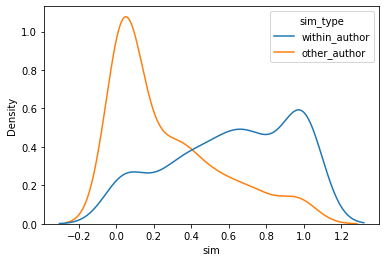

In [166]:
import numpy as np
np.random.seed(123)
from sklearn.metrics.pairwise import cosine_similarity
min_prior_comment_count = 5
author_submission_sim = []
author_other_submission_sim = []
submission_doc_array = np.array(submission_docs)
parent_submission_doc_array = np.array(parent_submission_docs)
valid_authors = sample_author_submission_comment_data.loc[:, 'author'].unique()
for author_i in valid_authors:
    # get all original submission indices that correspond to submissions to which author responded
    submission_idx_i = comment_data[comment_data.loc[:, 'comment_author']==author_i].loc[:, 'submission_title'].apply(lambda x: np.where(submission_doc_array == x)[0][0]).values
    # get all parent submission indices that correspond to submissions to which author (previously) responded
    parent_submission_idx_i = sample_author_submission_comment_data[sample_author_submission_comment_data.loc[:, 'author']==author_i].loc[:, 'parent_title'].apply(lambda x: np.where(parent_submission_doc_array == x)[0][0]).values
    submission_doc_topics_i = submission_doc_topics.iloc[submission_idx_i, :].mean(axis=0)
    parent_submission_doc_topics_i = parent_submission_doc_topics.iloc[parent_submission_idx_i, :].mean(axis=0)
    topic_sim_i = cosine_similarity(submission_doc_topics_i.values.reshape(1,-1), parent_submission_doc_topics_i.values.reshape(1,-1))[0][0]
    # add control sim??
    other_submission_idx_i = sample_author_submission_comment_data[sample_author_submission_comment_data.loc[:, 'author']!=author_i].loc[:, 'parent_title'].apply(lambda x: np.where(parent_submission_doc_array == x)[0][0]).values
    other_submission_idx_i = np.random.choice(other_submission_idx_i, len(parent_submission_idx_i), replace=False)
    other_submission_doc_topics_i = parent_submission_doc_topics.iloc[other_submission_idx_i, :].mean(axis=0)
    other_topic_sim_i = cosine_similarity(submission_doc_topics_i.values.reshape(1,-1), other_submission_doc_topics_i.values.reshape(1,-1))[0][0]
    author_submission_sim.append(topic_sim_i)
    author_other_submission_sim.append(other_topic_sim_i)
## combine data
author_submission_sim_data = pd.DataFrame([author_submission_sim+author_other_submission_sim, ['within_author',]*len(author_submission_sim)+['other_author',]*len(author_other_submission_sim)], index=['sim', 'sim_type']).transpose()
author_submission_sim_data = author_submission_sim_data.assign(**{
    'sim' : author_submission_sim_data.loc[:, 'sim'].astype(float)
})
display(author_submission_sim_data.head())
## plot both similarities
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(data=author_submission_sim_data, x='sim', hue='sim_type', common_norm=True)
plt.show()

Great! People on `r/news` tend to comment about the same topic as they previously did and tend to post about different topics as compared to other (random) people.

Do we see a division between "experts" and non-experts with respect to the topics? E.g. people who consistently comment on one topic over others.

We can assess this by looking at the unique number of users who post at least X% of their prior comments about a particular topic.

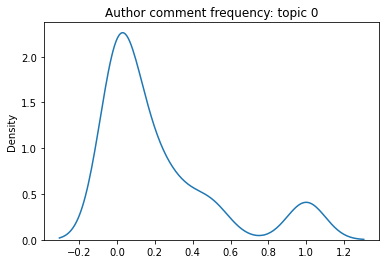

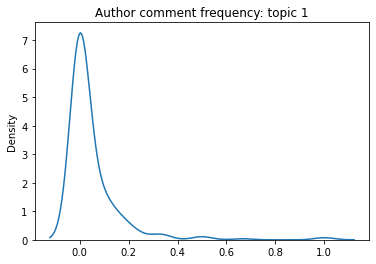

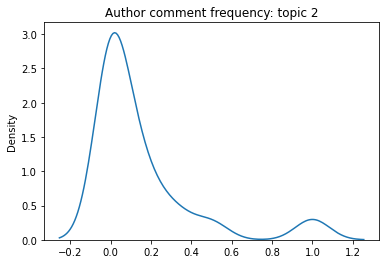

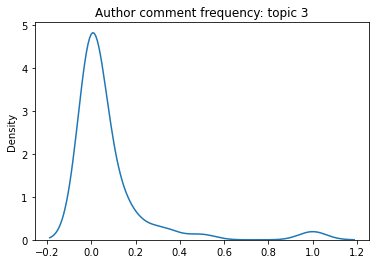

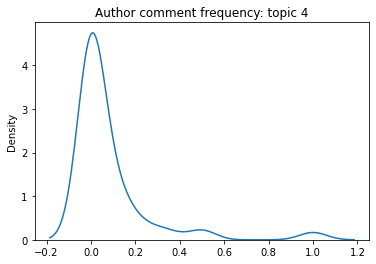

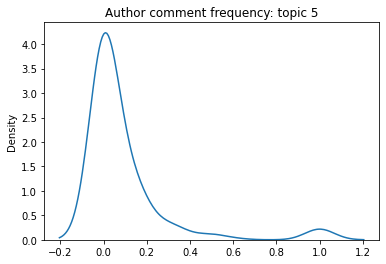

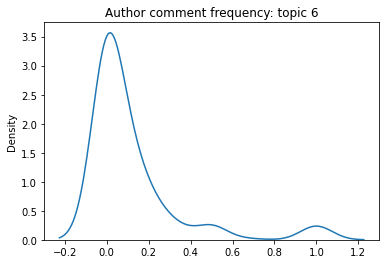

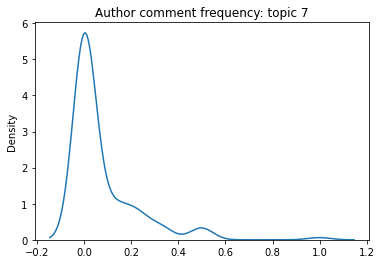

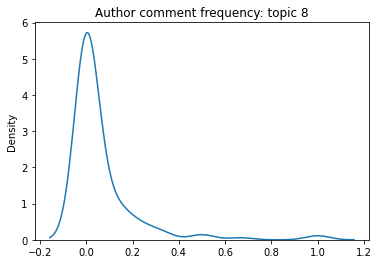

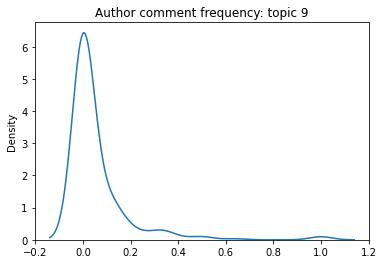

In [199]:
## separate by topic
num_topics = parent_submission_doc_topics.shape[1]
sample_authors = sample_author_submission_comment_data.loc[:, 'author'].unique()
## get distribution of topics per author
author_topic_dist = []
for author_i in sample_authors:
    parent_submission_idx_i = sample_author_submission_comment_data[sample_author_submission_comment_data.loc[:, 'author']==author_i].loc[:, 'parent_title'].apply(lambda x: np.where(parent_submission_doc_array == x)[0][0]).values
    topic_dist_i = parent_submission_doc_topics.iloc[parent_submission_idx_i, :].apply(lambda x: (x == x.max()).astype(int), axis=1)
    topic_dist_i = topic_dist_i.mean(axis=0)
    author_topic_dist.append(topic_dist_i)
author_topic_dist = np.vstack(author_topic_dist)
for topic_i in range(num_topics):
    sns.kdeplot(author_topic_dist[:, topic_i])
    plt.title(f'Author comment frequency: topic {topic_i}')
    plt.show()

Most people only comment a few times per topic, but we do see a small class of "outliers" who comment only on a particular topic (distribution bumps around 1.0).

### Test commenters in r/worldnews
Let's look into the comments on articles from `r/worldnews` to assess diversity of the user base.

Commenters here are likely to be more diverse and have more relevant experience on certain issues.

In [1]:
from praw import Reddit
def load_reddit_api():
    client_id = '9SCiZpAKCyfaTQ'
    client_secret = 'hQ2tGoUqpCizqJf2hNv0uP8cADw'
    user_agent = 'user_agent_123'
    reddit_api = Reddit(
        client_id=client_id,
        client_secret=client_secret,
        user_agent=user_agent,
        check_for_async=False,
    )
    return reddit_api

In [2]:
reddit_api = load_reddit_api()

In [3]:
from psaw import PushshiftAPI
from datetime import datetime
pushshift_reddit_api = PushshiftAPI(reddit_api)
start_date = (2018, 4, 1)
end_date = (2018, 4, 8)
start_time = int(datetime(*start_date).timestamp())
end_time = int(datetime(*end_date).timestamp())
subreddit_name = 'worldnews'
submissions = pushshift_reddit_api.search_submissions(
    after=start_time,
    before=end_time, 
    subreddit=subreddit_name,
)
from tqdm import tqdm
retrieved_submissions = []
for i, submission_i in tqdm(enumerate(submissions)):
    retrieved_submissions.append(submission_i)
    if(i % 100 == 0):
        print(f'{i} submissions processed')

0it [00:00, ?it/s]/home/ianbstew/miniconda3/envs/py3/lib/python3.8/site-packages/psaw/PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)
1it [00:03,  3.43s/it]

0 submissions processed


101it [00:11,  2.42s/it]

100 submissions processed


201it [00:15,  1.71s/it]

200 submissions processed


301it [00:18,  1.20s/it]

300 submissions processed


401it [00:21,  1.17it/s]

400 submissions processed


501it [00:28,  1.62it/s]

500 submissions processed


601it [00:30,  2.29it/s]

600 submissions processed


701it [00:31,  3.23it/s]

700 submissions processed


801it [00:34,  4.41it/s]

800 submissions processed


901it [00:37,  6.00it/s]

900 submissions processed


1001it [00:38,  8.33it/s]

1000 submissions processed


1101it [00:47,  9.04it/s]

1100 submissions processed


1201it [00:49, 11.88it/s]

1200 submissions processed


1301it [00:53, 14.02it/s]

1300 submissions processed


1401it [00:58, 15.63it/s]

1400 submissions processed


1501it [01:06, 14.35it/s]

1500 submissions processed


1601it [01:08, 18.52it/s]

1600 submissions processed


1701it [01:10, 22.19it/s]

1700 submissions processed


1801it [01:12, 27.47it/s]

1800 submissions processed


1901it [01:19, 21.33it/s]

1900 submissions processed


2001it [01:21, 25.64it/s]

2000 submissions processed


2101it [01:23, 31.03it/s]

2100 submissions processed


2201it [01:25, 32.25it/s]

2200 submissions processed


2301it [01:27, 35.96it/s]

2300 submissions processed


2401it [01:37, 20.96it/s]

2400 submissions processed


2501it [01:40, 23.88it/s]

2500 submissions processed


2601it [01:43, 25.32it/s]

2600 submissions processed


2701it [01:45, 28.87it/s]

2700 submissions processed


2801it [01:47, 36.05it/s]

2800 submissions processed


2901it [01:56, 21.13it/s]

2900 submissions processed


3001it [02:01, 20.95it/s]

3000 submissions processed


3101it [02:03, 24.15it/s]

3100 submissions processed


3201it [02:05, 29.78it/s]

3200 submissions processed


3301it [02:14, 20.06it/s]

3300 submissions processed


3401it [02:15, 26.09it/s]

3400 submissions processed


3501it [02:20, 23.39it/s]

3500 submissions processed


3601it [02:23, 25.58it/s]

3600 submissions processed


3701it [02:32, 18.70it/s]

3700 submissions processed


3801it [02:34, 23.71it/s]

3800 submissions processed


3901it [02:37, 25.07it/s]

3900 submissions processed


4001it [02:39, 29.22it/s]

4000 submissions processed


4101it [02:48, 19.68it/s]

4100 submissions processed


4201it [02:49, 25.11it/s]

4200 submissions processed


4301it [02:51, 32.26it/s]

4300 submissions processed


4401it [02:52, 37.69it/s]

4400 submissions processed


4501it [02:54, 43.91it/s]

4500 submissions processed


4601it [02:57, 40.00it/s]

4600 submissions processed


4701it [03:05, 22.99it/s]

4700 submissions processed


4801it [03:07, 28.08it/s]

4800 submissions processed


4901it [03:10, 30.33it/s]

4900 submissions processed


5001it [03:11, 35.40it/s]

5000 submissions processed


5101it [03:14, 36.23it/s]

5100 submissions processed


5201it [03:23, 21.69it/s]

5200 submissions processed


5301it [03:29, 20.18it/s]

5300 submissions processed


5401it [03:31, 24.78it/s]

5400 submissions processed


5501it [03:40, 17.98it/s]

5500 submissions processed


5601it [03:44, 19.11it/s]

5600 submissions processed


5701it [03:48, 20.93it/s]

5700 submissions processed


5801it [03:49, 27.50it/s]

5800 submissions processed


5857it [03:57, 24.67it/s]


In [4]:
import pandas as pd
from praw.models.reddit.more import MoreComments
def get_submission_comments(submissions):
    comment_data = []
    for i, submission_i in enumerate(submissions):
        id_i = submission_i.id
        title_i = submission_i.title
        url_i = submission_i.url
        upvote_i = submission_i.ups
        ratio_i = submission_i.upvote_ratio
        comments_i = list(submission_i.comments)
        for comment_j in comments_i:
            # add extra comments if needed
            if(type(comment_j) is MoreComments):
                extra_comments_i = comment_j.comments()
                comments_i.extend(extra_comments_i)
            else:
                comment_id_j = comment_j.id
                comment_text_j = comment_j.body
                comment_upvote_j = comment_j.ups
                comment_author_j = comment_j.author
                comment_author_name_j = ''
                if(comment_author_j is not None):
                    comment_author_name_j = comment_author_j.name
                comment_data_j = pd.Series(
                    [id_i, title_i, url_i, upvote_i, ratio_i, comment_id_j, comment_text_j, comment_upvote_j, comment_author_name_j],
                    index=['submission_ID', 'submission_title', 'submission_URL', 'submission_upvotes',
                           'submission_upvote_ratio', 'comment_ID', 'comment_text', 'comment_upvotes', 'comment_author']
                )
                comment_data.append(comment_data_j)
        if(i % 100 == 0):
            print(f'processed {i} submissions')
    comment_data = pd.concat(comment_data, axis=1).transpose()
    return comment_data

In [5]:
comment_data = get_submission_comments(retrieved_submissions)

processed 0 submissions
processed 100 submissions
processed 200 submissions
processed 300 submissions
processed 400 submissions
processed 500 submissions
processed 600 submissions
processed 700 submissions
processed 800 submissions
processed 900 submissions
processed 1000 submissions
processed 1100 submissions
processed 1200 submissions
processed 1300 submissions
processed 1400 submissions
processed 1500 submissions
processed 1600 submissions
processed 1700 submissions
processed 1800 submissions
processed 1900 submissions
processed 2000 submissions
processed 2100 submissions
processed 2200 submissions
processed 2300 submissions
processed 2400 submissions
processed 2500 submissions
processed 2600 submissions
processed 2700 submissions
processed 2800 submissions
processed 2900 submissions
processed 3000 submissions
processed 3100 submissions
processed 3200 submissions
processed 3300 submissions
processed 3400 submissions
processed 3500 submissions
processed 3600 submissions
processed 370

In [6]:
print(f'{comment_data.loc[:, "comment_author"].nunique()} comment authors')

18654 comment authors


In [54]:
## get sample comments from sample authors
import numpy as np
np.random.seed(123)
from tqdm import tqdm
from praw.models.reddit.comment import Comment
from praw.models.reddit.submission import Submission
def get_sample_author_posts(author, reddit_api, end_time, comment_cols, submission_cols, post_count=1000):
    author_posts = []
    author_redditor = reddit_api.redditor(author)
    complete_comment_cols = comment_cols+['author', 'subreddit', 'post_type']
    complete_submission_cols = submission_cols+['author', 'subreddit', 'post_type']
    try:
        for i, post_i in enumerate(author_redditor.new(limit=None)):
            # make sure it's a comment lol
            post_time_i = post_i.created_utc
            if(post_time_i <= end_time):
                subreddit_i = post_i.subreddit.display_name
                if(type(post_i) is Comment and post_i.body is not None):
                    post_data_i = [post_i.__dict__.get(x) for x in comment_cols] + [author, subreddit_i, 'comment']
                    post_data_i = pd.Series(post_data_i, index=complete_comment_cols)
                elif(type(post_i) is Submission and post_i.selftext is not None):
                    post_data_i = [post_i.__dict__.get(x) for x in submission_cols] + [author, subreddit_i, 'submission']
                    post_data_i = pd.Series(post_data_i, index=complete_submission_cols)
                if(type(post_i) is Comment or type(post_i) is Submission):
                    author_posts.append(post_data_i)
            if(len(author_posts) >= post_count):
                break
    # error: deleted author account?
    except Exception as e:
        print(f'ending collection for author {author} because error {e}')
    if(len(author_posts) > 0):
        # tmp debugging
#         print(f'author posts = {author_posts}')
        author_posts = pd.concat(author_posts, axis=1).transpose()
    return author_posts
sample_author_count = 1000
sample_post_count = 1000
sample_authors = np.random.choice(comment_data.loc[:, 'comment_author'].unique(), sample_author_count, replace=False)
sample_author_posts = []
comment_cols = ['author_flair_text', 'id', 'body', 'parent_id']
submission_cols = ['author_flair_text', 'id', 'selftext', 'title']
end_date = (2018, 4, 2)
end_time = int(datetime(*end_date).timestamp())
for sample_author_i in tqdm(sample_authors):
    sample_author_posts_i = get_sample_author_posts(sample_author_i, reddit_api, end_time, comment_cols, submission_cols, post_count=sample_post_count)
    sample_author_posts.append(sample_author_posts_i)
# remove null comments
sample_author_posts = list(filter(lambda x: type(x) is not list, sample_author_posts))
sample_author_posts = pd.concat(sample_author_posts, axis=0)
# remove null comments
sample_author_posts = sample_author_posts[sample_author_posts.loc[:, 'body'].apply(lambda x: x is not None)]

<ipython-input-54-5acf97b9aa26>:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sample_author_posts = pd.concat(sample_author_posts, axis=0)


In [59]:
## combine text fields
sample_author_posts = sample_author_posts.assign(**{
    'text' : sample_author_posts.apply(lambda x: x.loc['body'] if x.loc['post_type']=='comment' else x.loc['selftext'], axis=1)
})
## remove null posts
sample_author_posts = sample_author_posts[sample_author_posts.loc[:, 'text']!='[removed]']

In [60]:
## save to file
sample_author_posts.to_csv('../../data/reddit_data/reddit_worldnews_author_post_sample.gz', sep='\t', compression='gzip', index=False)

In [63]:
## posts per author?
import numpy as np
print(np.median(sample_author_posts.loc[:, 'author'].value_counts()))

73.0


We have about 70 posts per author, which isn't too much.

In [65]:
## age, location
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import extract_age, full_location_pipeline
from stanza import Pipeline
from nltk.tokenize import PunktSentenceTokenizer
import re
from tqdm import tqdm
nlp_pipeline = Pipeline(lang='en', processors='tokenize,ner', use_gpu=False)
sent_tokenizer = PunktSentenceTokenizer()
location_matcher = re.compile('(?<=i\'m from )[a-zA-Z0-9\, ]+|(?<=i am from )[a-zA-Z0-9\, ]+|(?<=i live in )[a-zA-Z0-9 ]+')
sample_author_meta_data = []
valid_NE_types = {'GPE'}
for author_i, data_i in tqdm(sample_author_posts.groupby('author')):
    text_i = data_i.loc[:, 'text'].values
    age_i = extract_age(text_i)
    loc_i = full_location_pipeline(text_i, location_matcher, sent_tokenizer, nlp_pipeline, valid_NE_types=valid_NE_types)
    sample_author_meta_data.append([author_i, age_i, loc_i])
sample_author_meta_data = pd.DataFrame(sample_author_meta_data, columns=['author', 'age', 'location'])

2021-02-11 00:09:28 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| ner       | ontonotes |

2021-02-11 00:09:28 INFO: Use device: cpu
2021-02-11 00:09:28 INFO: Loading: tokenize
2021-02-11 00:09:28 INFO: Loading: ner
2021-02-11 00:09:29 INFO: Done loading processors!
100%|██████████| 873/873 [09:22<00:00,  1.55it/s]  


In [66]:
print(sample_author_meta_data.loc[:, 'age'].value_counts())
print(sample_author_meta_data.loc[:, 'location'].value_counts())

-1     861
 32      2
 22      2
 35      1
 30      1
 27      1
 25      1
 21      1
 20      1
 19      1
 15      1
Name: age, dtype: int64
UNK    751
us      65
ca      17
gb       6
au       5
se       3
nl       3
de       2
fr       2
bg       2
eg       1
ie       1
vn       1
tw       1
cl       1
ke       1
il       1
dk       1
fi       1
ga       1
be       1
nz       1
br       1
co       1
sa       1
es       1
no       1
Name: location, dtype: int64


Similar to before, we find that most authors are from US/CA/UK, and other authors have a long tail of other countries.

What about topics? Let's get the topics of all submissions to `r/worldnews` based on headlines, and compare the distribution of topical interest in the same way as last time.

In [68]:
news_sample_author_comments = sample_author_posts[(sample_author_posts.loc[:, 'subreddit']=='worldnews') & 
                                                  (sample_author_posts.loc[:, 'post_type']=='comment')]
print(f'{news_sample_author_comments.shape[0]} comments in worldnews')

5819 comments in worldnews


In [69]:
from tqdm import tqdm
news_comment_parent_ids = news_sample_author_comments.loc[:, 'parent_id'].apply(lambda x: x.split('_')[1]).unique()
news_comment_parent_submission_data = []
for parent_id_i in tqdm(news_comment_parent_ids):
    parent_submission_i = reddit_api.submission(parent_id_i)
    # try to retrieve submission
    try:
        parent_title_i = parent_submission_i.title
#         print(f'title = {parent_title_i}')
        parent_upvotes_i = parent_submission_i.ups
        parent_upvote_ratio_i = parent_submission_i.upvote_ratio
        parent_submission_data_i = [parent_id_i, parent_title_i, parent_upvotes_i, parent_upvote_ratio_i]
        parent_submission_data_i = pd.Series(parent_submission_data_i, index=['parent_id', 'parent_title', 'parent_upvotes', 'parent_upvote_ratio'])
        news_comment_parent_submission_data.append(parent_submission_data_i)
    except Exception as e:
#         print(f'error = {e}')
        pass
news_comment_parent_submission_data = pd.concat(news_comment_parent_submission_data, axis=1).transpose()

100%|██████████| 5611/5611 [57:26<00:00,  1.63it/s]  


In [75]:
## topic modeling
from gensim.models import LdaModel
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import convert_docs_to_corpus
## combine original submission titles, parent submissions
comment_submission_titles = list(comment_data.loc[:, 'submission_title'].unique())
prior_comment_submission_titles = list(news_comment_parent_submission_data.loc[:, 'parent_title'].unique())
combined_submission_title_text = comment_submission_titles + prior_comment_submission_titles
combined_submission_dict, combined_submission_corpus = convert_docs_to_corpus(combined_submission_title_text)

In [77]:
from gensim.models import CoherenceModel
# fit model
num_topics = [10, 20, 50, 100]
coherence_vals = []
for num_topic_i in num_topics:
    lda_model = LdaModel(combined_submission_corpus, num_topics=num_topic_i, id2word=combined_submission_dict)
    # compute coherence
    coherence_model = CoherenceModel(model=lda_model, corpus=combined_submission_corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    coherence_vals.append(coherence)
print(coherence_vals)
# compute all topics
from data_helpers import convert_docs_to_topics
best_num_topics = 10
best_lda_model = LdaModel(combined_submission_corpus, num_topics=best_num_topics, id2word=combined_submission_dict)
comment_submission_doc_topics = convert_docs_to_topics(comment_submission_titles, combined_submission_dict, best_lda_model)
prior_comment_submission_doc_topics = convert_docs_to_topics(prior_comment_submission_titles, combined_submission_dict, best_lda_model)

[-8.820670706007935, -11.02058477237412, -13.99435710157899, -14.040291273031059]


In [80]:
display(best_lda_model.print_topics(num_words=20))

[(0,
  '0.028*"s" + 0.020*"news" + 0.016*"korea" + 0.015*"us" + 0.014*"china" + 0.012*"north" + 0.011*"says" + 0.010*"u" + 0.009*"trump" + 0.009*"today" + 0.008*"un" + 0.007*"bangla" + 0.006*"will" + 0.006*"2018" + 0.006*"russia" + 0.005*"live" + 0.005*"april" + 0.005*"south" + 0.005*"jong" + 0.005*"tv"'),
 (1,
  '0.019*"s" + 0.009*"bbc" + 0.008*"leader" + 0.007*"will" + 0.007*"police" + 0.006*"jerusalem" + 0.006*"sex" + 0.006*"president" + 0.005*"uk" + 0.005*"state" + 0.004*"people" + 0.004*"tells" + 0.004*"russian" + 0.004*"thousands" + 0.004*"citizens" + 0.003*"trump" + 0.003*"term" + 0.003*"court" + 0.003*"merkel" + 0.003*"ex"'),
 (2,
  '0.031*"s" + 0.013*"russia" + 0.010*"‘" + 0.008*"u" + 0.008*"russian" + 0.007*"new" + 0.007*"trump" + 0.006*"first" + 0.006*"un" + 0.006*"kim" + 0.005*"world" + 0.005*"jong" + 0.005*"youtube" + 0.005*"will" + 0.005*"us" + 0.005*"minister" + 0.004*"china" + 0.004*"india" + 0.004*"uk" + 0.004*"canada"'),
 (3,
  '0.009*"brexit" + 0.008*"s" + 0.007*"ear

- 0: `asian politics`
- 1: `europe politics`
- 2: `international politics`
- 3: `middle east politics` (?)
- 4: `trump`
- 5: `terrorism` (?)
- 6: `energy`
- 7: `security` (?)
- 8: `military`
- 9: `science`

How much do people tend to stick to the same topic?

In [90]:
sample_author_post_comments = sample_author_posts[sample_author_posts.loc[:, 'post_type']=='comment']
sample_author_post_comments = sample_author_post_comments.assign(**{'parent_id' : sample_author_post_comments.loc[:, 'parent_id'].apply(lambda x: x.split('_')[-1])})
# get parent post titles
sample_author_post_comments = pd.merge(
    sample_author_post_comments.loc[:, ['parent_id', 'author']], 
    news_comment_parent_submission_data.loc[:, ['parent_id', 'parent_title']],
    on='parent_id',
)

In [91]:
sample_author_post_comments.head()

,parent_id,author,parent_title
0,7lvtuc,malchirx,Saudi Arabia bars Israelis from chess tournament
1,7lvtuc,soulassssns,Saudi Arabia bars Israelis from chess tournament
2,7g3f51,malchirx,Former Israeli Minister 'Proud' of Killing The...
3,6us4pw,malchirx,An Israeli cabinet minister has said relations...
4,55htj0,malchirx,Two-thirds of Israelis think peace deal won’t ...


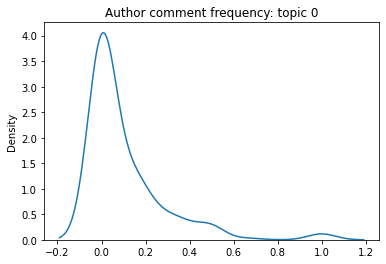

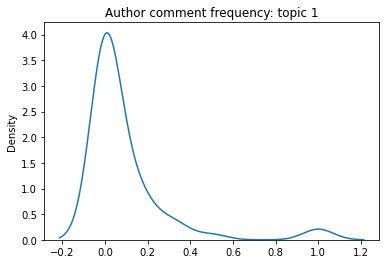

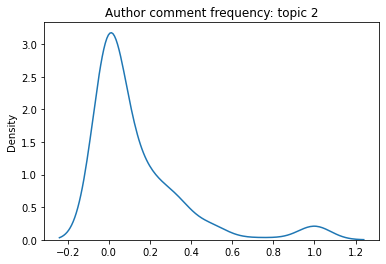

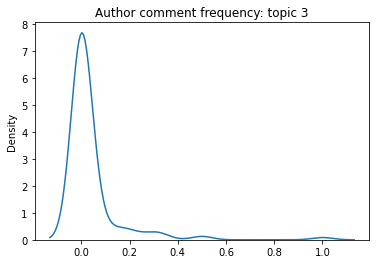

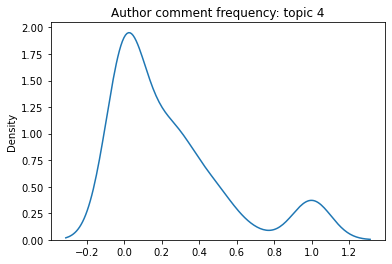

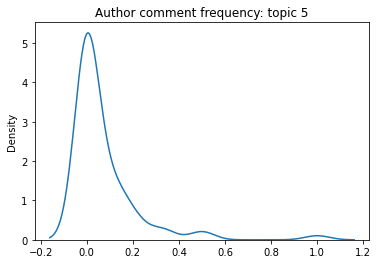

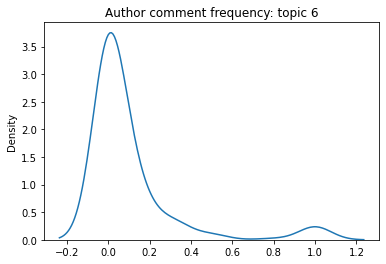

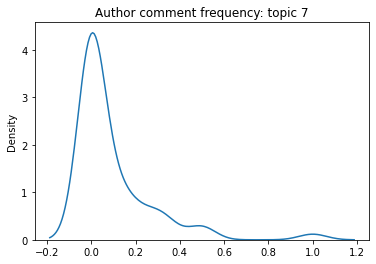

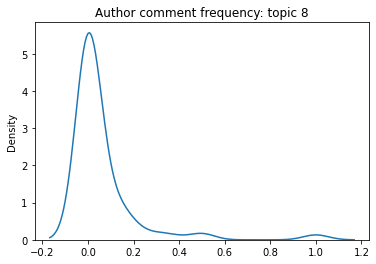

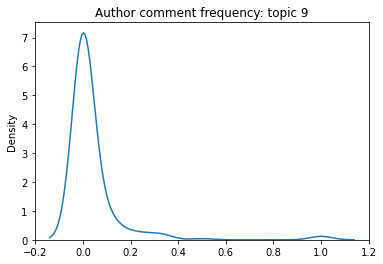

In [95]:
## separate by topic
num_topics = prior_comment_submission_doc_topics.shape[1]
sample_authors = sample_author_post_comments.loc[:, 'author'].unique()
prior_comment_submission_doc_array = np.array(prior_comment_submission_titles)
## get distribution of topics per author
author_topic_dist = []
for author_i in sample_authors:
    prior_submission_idx_i = sample_author_post_comments[sample_author_post_comments.loc[:, 'author']==author_i].loc[:, 'parent_title'].apply(lambda x: np.where(prior_comment_submission_doc_array == x)[0][0]).values
    topic_dist_i = prior_comment_submission_doc_topics.iloc[prior_submission_idx_i, :].apply(lambda x: (x == x.max()).astype(int), axis=1)
    topic_dist_i = topic_dist_i.mean(axis=0)
    author_topic_dist.append(topic_dist_i)
author_topic_dist = np.vstack(author_topic_dist)
## plot distribution
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
for topic_i in range(num_topics):
    sns.kdeplot(author_topic_dist[:, topic_i])
    plt.title(f'Author comment frequency: topic {topic_i}')
    plt.show()

Not surprisingly, the topic with the most "experts" is the one related to Trump (4). We also see notable "bumps" for international politics (2) and energy (6).

### Explore article overlap
How many of the submissions shown here are represented in our NYT article data?

In [9]:
## load news data
import pandas as pd
# news_comment_data = pd.read_csv('../../data/reddit_data/reddit_news_comment_sample.gz', sep='\t', compression='gzip', index_col=False)
print(news_comment_data.shape[0])
## label questions
from data_helpers import extract_questions
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
import re
word_tokenizer = WordPunctTokenizer()
sent_tokenizer = PunktSentenceTokenizer()
question_matcher = re.compile('.+[a-z0-9]\?$')
# test_text = 'this is a question? OK.'
# extract_questions(test_text, word_tokenizer, sent_tokenizer, question_matcher)
news_comment_data = news_comment_data.assign(**{
    'questions' : news_comment_data.loc[:, 'comment_text'].apply(lambda x: extract_questions(x, word_tokenizer, sent_tokenizer, question_matcher))
})
display(news_comment_data.head(5))

4585


,submission_ID,submission_title,submission_URL,submission_upvotes,submission_upvote_ratio,comment_ID,comment_text,comment_upvotes,comment_author,comment_questions,URL_domain,questions
0,88wlu3,Africa Egyptian government threatens foreign j...,https://www.independent.co.uk/news/world/afric...,94,0.91,dwo5e9a,Africa Egyptian? As opposed to regular Egyptian?,13,johnsoone,['As opposed to regular Egyptian?'],independent.co.uk,[As opposed to regular Egyptian?]
1,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwo1cjb,Just got our first home infestation within the...,96,jfoobar,[],usatoday.com,[]
2,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwnsk0j,"ah, fuck. are you allowed to take diatomaceous...",459,SomethingWitty4this,['are you allowed to take diatomaceous earth o...,usatoday.com,[are you allowed to take diatomaceous earth on...
3,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwntgsb,Burn down the airport,306,VTFC,[],usatoday.com,[]
4,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2347,0.95,dwnxjqv,The passenger who carried the bugs into the te...,96,Gasonfires,[],usatoday.com,[]


In [13]:
article_data = pd.read_csv('../../data/nyt_comments/ArticlesApril2018.csv', sep=',', index_col=False)
display(article_data.head())

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [17]:
import re
submission_URLs = news_comment_data.loc[:, 'submission_URL'].unique()
article_URLs = article_data.loc[:, 'webURL'].unique()
article_URL_matcher = re.compile('|'.join(article_URLs))
overlap_URLs = list(filter(lambda x: article_URL_matcher.search(x) is not None, submission_URLs))
print(overlap_URLs)
print(submission_URLs[:10])
print(article_URLs[:10])

[]
['https://www.independent.co.uk/news/world/africa/election-egypt-threat-journalist-president-sisi-summon-a8283406.html'
 'https://www.usatoday.com/story/travel/flights/todayinthesky/2018/04/01/bed-bugs-found-kansas-city-airport-seating-area/476933002/'
 'https://www.ajc.com/news/national/convenience-store-clerk-charged-with-murder-after-shooting-teen-for-stealing-beer-police-say/slralaZieHMX2VvSMdqebM/'
 'https://www.freep.com/story/money/cars/2018/04/01/mustang-chase-colorado/476671002/?from=new-cookie'
 'https://www.theguardian.com/world/2018/apr/02/tiangong-1-crash-china-space-station?utm_source=inshorts&utm_medium=referral&utm_campaign=fullarticle'
 'http://www.fresnobee.com/news/local/crime/article207277464.html'
 'https://www.reuters.com/article/us-usa-trade-china/china-imposes-additional-tariffs-in-response-to-u-s-duties-on-steel-aluminum-idUSKCN1H81J3?il=0'
 'http://www.foxnews.com/us/2018/04/01/new-york-museum-slammed-after-hiring-white-curator-for-african-art-exhibit.html'

OK! No overlap. This could be the result of different URL formats that are inconsistent.

### Old code

In [4]:
## code breaks when Pushshift is down LOL
from datetime import datetime
test_author = 'johnsoone'
end_date = (2018, 4, 2)
end_time = int(datetime(*end_date).timestamp())
author_sample_size = 1000
for x in pushshift_reddit_api.search_comments(before=end_date,author=test_author):
    print(x)
    break

Exception: Unable to connect to pushshift.io. Max retries exceeded.

In [16]:
## first: collect random sample of question askers
question_comment_data = comment_data[comment_data.loc[:, 'comment_questions'].apply(lambda x: len(x) > 0)]
np.random.seed(123)
author_sample_size = 1000
sample_question_authors = np.random.choice(question_comment_data.loc[:, 'comment_author'].unique(), author_sample_size, replace=False)
sample_question_author_comment_data = []
end_date = (2018, 4, 2)
end_time = int(datetime(*end_date).timestamp())
comments_per_author = 1000
for sample_question_author in sample_question_authors:
    ## mine previous 1000 comments by author
    reddit_api.user
    pass

,submission_ID,submission_title,submission_URL,submission_upvotes,submission_upvote_ratio,comment_ID,comment_text,comment_upvotes,comment_author,comment_questions,URL_domain
0,88wlu3,Africa Egyptian government threatens foreign j...,https://www.independent.co.uk/news/world/afric...,98,0.91,dwo5e9a,Africa Egyptian? As opposed to regular Egyptian?,13,johnsoone,[As opposed to regular Egyptian?],independent.co.uk
1,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2354,0.95,dwo1cjb,Just got our first home infestation within the...,94,jfoobar,[],usatoday.com
2,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2354,0.95,dwnsk0j,"ah, fuck. are you allowed to take diatomaceous...",464,SomethingWitty4this,[are you allowed to take diatomaceous earth on...,usatoday.com
3,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2354,0.95,dwntgsb,Burn down the airport,309,VTFC,[],usatoday.com
4,88wkce,Bed bugs found in Kansas City airport seating ...,https://www.usatoday.com/story/travel/flights/...,2354,0.95,dwnxjqv,The passenger who carried the bugs into the te...,92,Gasonfires,[],usatoday.com
